## **1. Algorithms Selected: Description and Justification**

In this phase, we applied unsupervised learning through clustering to group semantically similar data points, aiming to enhance our recommendation system.

Given that our dataset consists of text data, we utilize transformer-based embeddings to represent the semantic content of each sample. Specifically, we use two different embedding models:

* **MPNet embeddings** : which are known for capturing rich contextual information and robust semantic representations.

* **MiniLM embeddings** : a lightweight transformer model optimized for efficiency while maintaining good semantic encoding.

For clustering, we selected K-Means with MPNet embeddings, leveraging the Euclidean geometry of the dense vector space produced by MPNet. K-Means is well-suited here due to its simplicity, scalability, and effectiveness in clustering dense, continuous vector representations.

For the MiniLM embeddings, we applied clustering based on cosine similarity because MiniLM embeddings often perform better when similarity is measured by angular distance rather than Euclidean distance.

In [ ]:
#installing the required libraries
!pip install xgboost
!pip install transformers
!pip install sentence-transformers
!pip install scikit-learn

In [26]:
import pandas as pd
import os
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import ast
import matplotlib.pyplot as plt


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
movies_df = pd.read_csv("/content/drive/MyDrive/Movie_Recommendation/movies.csv", low_memory=False)

In [29]:
reduced_df = pd.read_csv("/content/drive/MyDrive/Movie_Recommendation/processed_merged_df.csv", low_memory=False)

For integration with our supervised learning models, we filtered the clustering dataset to retain only movies whose IDs appeared in the training data. Additionally, to manage computational resources and prevent Colab crashes due to the high dimensionality of text features, we further reduced the dataset by limiting the number of ratings per movie to a maximum of 200. This trade-off ensured feasible model training while maintaining a representative sample of the data.

In [30]:
common_movie_ids = reduced_df['movieId'].unique()

movies_df = movies_df[movies_df['id'].isin(common_movie_ids)]


In [31]:
N = 200

reduced_sampled = (
    reduced_df.groupby("movieId")
               .apply(lambda x: x.sample(n=min(len(x), N), random_state=42))
               .reset_index(drop=True)
)

print("Final reduced:", reduced_sampled.shape)


Final reduced: (586979, 18)


/tmp/ipython-input-1314824862.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [32]:
common_movie_ids_2 = reduced_sampled['movieId'].unique()

movies_df = movies_df[movies_df['id'].isin(common_movie_ids_2)]


In [33]:
movies_df.to_csv("Final_movies.csv", index=False)


### **A. MPnet + K-Means Clustering**

In [34]:
# -*- coding: utf-8 -*-
"""Phase3_MPnet_Clustering.ipynb
"""

# Check if drive is already mounted
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("Drive already mounted!")

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import ast

# ============================================================================
# LOAD DATA
# ============================================================================

print("Loading movie data...")

print(f"Original dataset shape: {movies_df.shape}")


# Note: Removing any rating/class labels as required for unsupervised learning
# We keep only: id, title, overview, genres for clustering
movies_clean = movies_df[['id', 'title', 'overview', 'genre1','genre2']].copy()

# Combine text for embeddings
movies_clean['combined_text'] = (
    movies_clean['title'] + '. ' +
    movies_clean['overview'] + ' Genres: ' +
    movies_clean['genre1']+ ' '+movies_clean['genre2']
)

# Sample if needed (adjust based on your resources)

print(f"Processed dataset shape: {movies_clean.shape}")
print("Note: Class labels (ratings) have been removed for unsupervised clustering")

# ============================================================================
# LOAD MPnet MODEL
# ============================================================================

print("\n" + "="*80)
print("LOADING MPnet MODEL")
print("="*80)

mpnet_model = SentenceTransformer('all-mpnet-base-v2')

print(f"\nModel loaded successfully!")
print(f"Embedding dimension: {mpnet_model.get_sentence_embedding_dimension()}")

# ============================================================================
# GENERATE EMBEDDINGS
# ============================================================================

print("\n" + "="*80)
print("GENERATING MOVIE EMBEDDINGS")
print("="*80)

movie_embeddings = mpnet_model.encode(
    movies_clean['combined_text'].tolist(),
    show_progress_bar=True,
    batch_size=32,
    normalize_embeddings=True
)

print(f"\nEmbeddings generated!")
print(f"Embeddings shape: {movie_embeddings.shape}")
print(f"Embedding dimension: {movie_embeddings.shape[1]}")


Drive already mounted!
Loading movie data...
Original dataset shape: (5848, 18)
Processed dataset shape: (5848, 6)
Note: Class labels (ratings) have been removed for unsupervised clustering

LOADING MPnet MODEL

Model loaded successfully!
Embedding dimension: 768

GENERATING MOVIE EMBEDDINGS


Batches:   0%|          | 0/183 [00:00<?, ?it/s]


Embeddings generated!
Embeddings shape: (5848, 768)
Embedding dimension: 768


**How did we determine the number of Clusters**


To select the optimal number of clusters, we applied the **Elbow Method** by evaluating K-Means clustering with values of *k* ranging from 1 to 20. We analyzed the Total Within-Cluster Sum of Squares (WCSS) for each *k* and chose the point where adding more clusters provided diminishing returns in reducing WCSS. This approach helped us balance cluster compactness and model complexity.


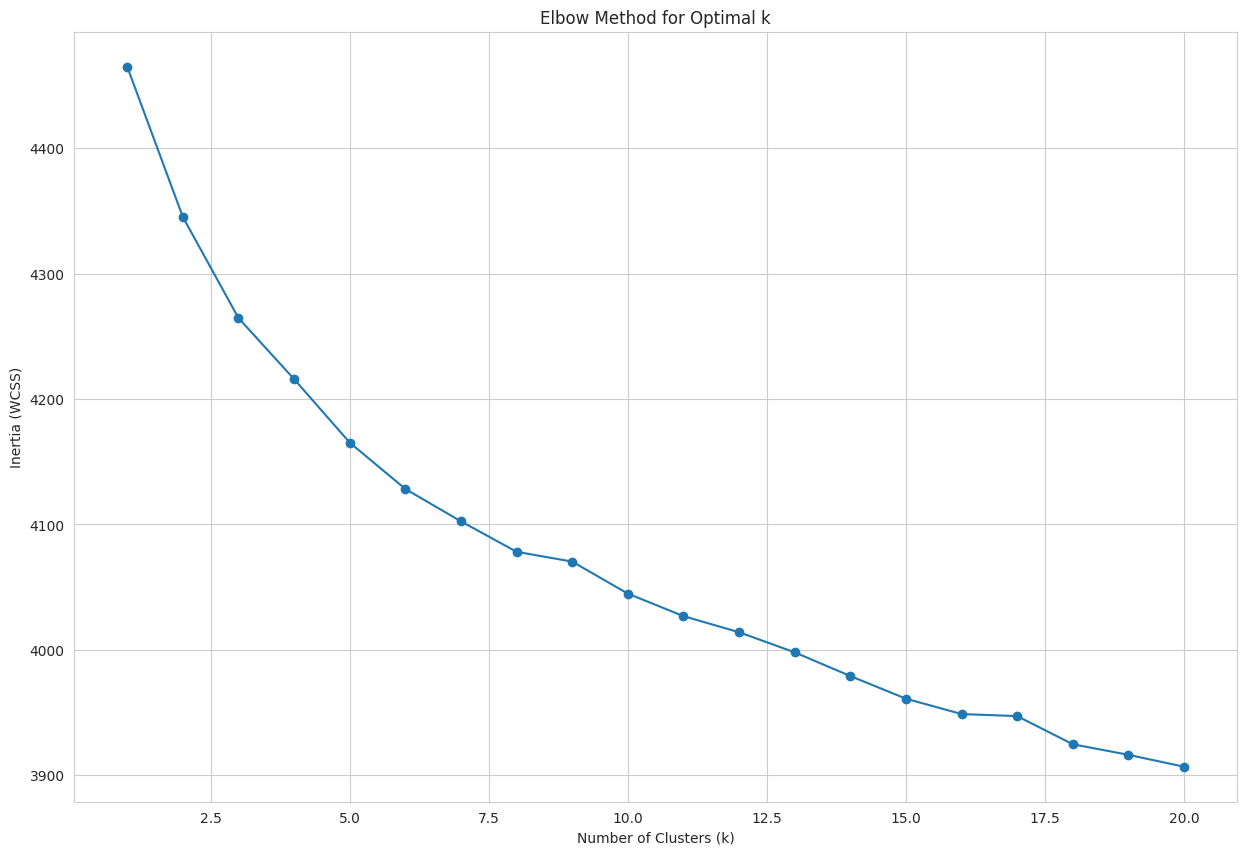

In [35]:
import matplotlib.pyplot as plt

inertia_values = []
k_values = range(1, 21)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(movie_embeddings)
    inertia_values.append(km.inertia_)

plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [36]:

# ============================================================================
# APPLY K-MEANS CLUSTERING
# ============================================================================

print("\n" + "="*80)
print("APPLYING K-MEANS CLUSTERING")
print("="*80)

# Set number of clusters
# You can adjust this value based on your dataset
NUM_CLUSTERS = 6

print(f"\nClustering movies into {NUM_CLUSTERS} clusters...")

# Apply K-Means clustering
kmeans = KMeans(
    n_clusters=NUM_CLUSTERS,
    random_state=42,
    n_init=10,
    max_iter=300
)

# Fit and predict clusters
cluster_labels = kmeans.fit_predict(movie_embeddings)

# Add cluster labels to dataframe
movies_clean['cluster'] = cluster_labels

print(f"Clustering completed!")
print(f"Movies assigned to {NUM_CLUSTERS} clusters")

# ============================================================================
# CLUSTER ANALYSIS - SHOW SAMPLE MOVIES FROM EACH CLUSTER
# ============================================================================

print("\n" + "="*80)
print("SAMPLE MOVIES FROM EACH CLUSTER")
print("="*80)

for cluster_id in range(NUM_CLUSTERS):
    cluster_movies = movies_clean[movies_clean['cluster'] == cluster_id]

    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Number of movies: {len(cluster_movies)}")

    print("\nSample movies:")
    for idx, (_, movie) in enumerate(cluster_movies.head(5).iterrows(), 1):
        print(f"\n{idx}. {movie['title']}")
        print(f"   Genres: {movie['genre1']}")
        print(f"   Overview: {movie['overview'][:120]}...")

# ============================================================================
# SAVE RESULTS
# ============================================================================

print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save embeddings
np.save('/content/drive/MyDrive/Movie_Recommendation/mpnet_embeddings.npy', movie_embeddings)

# Save clustered movies
movies_clean[['id', 'title', 'genre1','genre2' ,'cluster']].to_csv(
    '/content/drive/MyDrive/Movie_Recommendation/mpnet_clustered_movies.csv',
    index=False
)

# Save cluster centers
np.save('/content/drive/MyDrive/Movie_Recommendation/mpnet_cluster_centers.npy', kmeans.cluster_centers_)

print("\nFiles saved:")
print("  1. mpnet_embeddings.npy - Movie embeddings (768D vectors)")
print("  2. mpnet_clustered_movies.csv - Movies with cluster assignments")
print("  3. mpnet_cluster_centers.npy - Cluster centers")

print("\n" + "="*80)
print("MPnet CLUSTERING COMPLETED!")
print("="*80)



APPLYING K-MEANS CLUSTERING

Clustering movies into 6 clusters...
Clustering completed!
Movies assigned to 6 clusters

SAMPLE MOVIES FROM EACH CLUSTER

CLUSTER 0
Number of movies: 1268

Sample movies:

1. Sense and Sensibility
   Genres: Drama
   Overview: Rich Mr. Dashwood dies, leaving his second wife and her daughters poor by the rules of inheritance. Two daughters are th...

2. Leaving Las Vegas
   Genres: Drama
   Overview: Ben Sanderson, an alcoholic Hollywood screenwriter who lost everything because of his drinking, arrives in Las Vegas to ...

3. To Die For
   Genres: Fantasy
   Overview: Susan wants to work in television and will therefore do anything it takes, even if it means killing her husband. A very ...

4. When Night Is Falling
   Genres: Drama
   Overview: A prudish woman, working on tenure as a literacy professor at a large urban university, finds herself strangely attracte...

5. French Twist
   Genres: Comedy
   Overview: After learning of her husband's infidelitie

In [37]:
from sklearn.metrics import silhouette_score
silhouette_score(movie_embeddings, cluster_labels)

np.float32(0.018303946)

Although we used the Elbow Method to select the optimal number of clusters, the resulting Silhouette Coefficient was low (approximately 0.0183), indicating poor cluster separation and suggesting that the data may not form well-defined clusters in the embedding space.

CLUSTER VISUALIZATION SUITE

1. Generating t-SNE 2D projection...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5848 samples in 0.001s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computed neighbors for 5848 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5848
[t-SNE] Computed conditional probabilities for sample 2000 / 5848
[t-SNE] Computed conditional probabilities for sample 3000 / 5848
[t-SNE] Computed conditional probabilities for sample 4000 / 5848
[t-SNE] Computed conditional probabilities for sample 5000 / 5848
[t-SNE] Computed conditional probabilities for sample 5848 / 5848
[t-SNE] Mean sigma: 0.246166
[t-SNE] KL divergence after 50 iterations with early exaggeration: 88.863197
[t-SNE] KL divergence after 1000 iterations: 2.934054


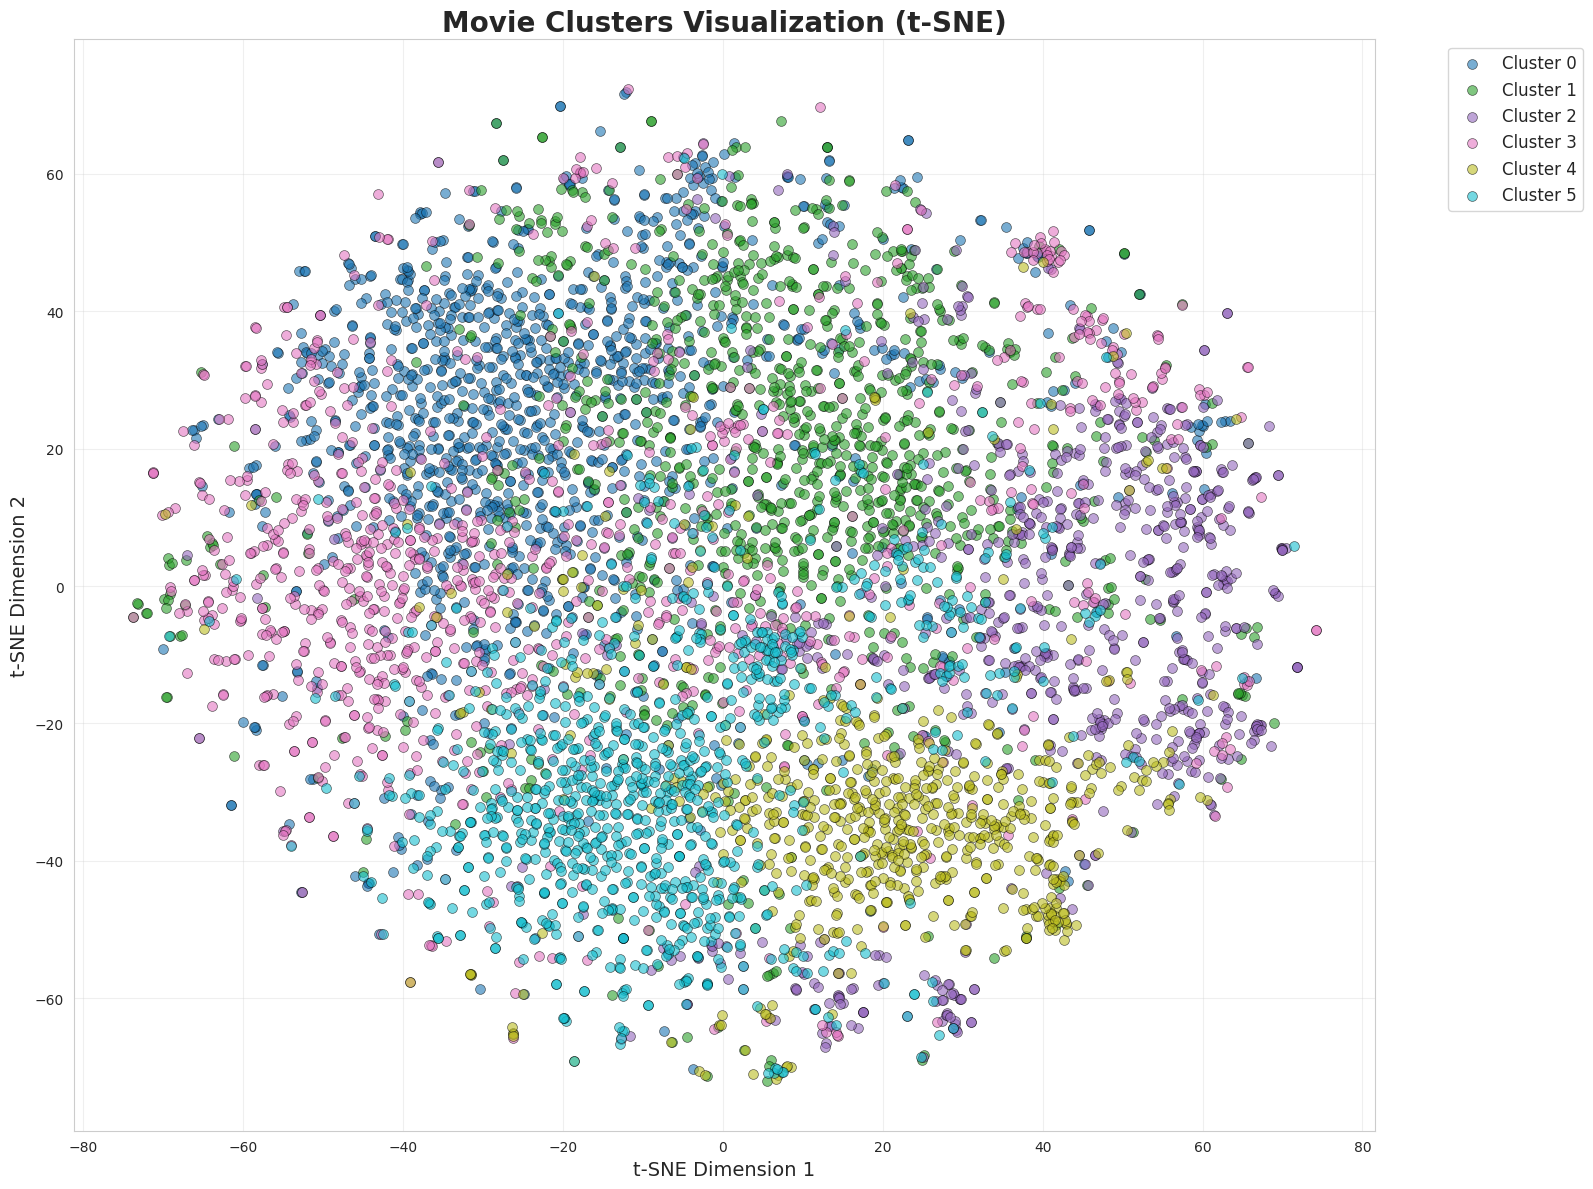

✅ t-SNE visualization saved!

2. Creating interactive Plotly visualization...


✅ Interactive plot saved as HTML!

3. Generating 3D t-SNE projection...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



✅ 3D visualization saved!

4. Generating PCA 2D projection...
PCA explained variance: 7.24%


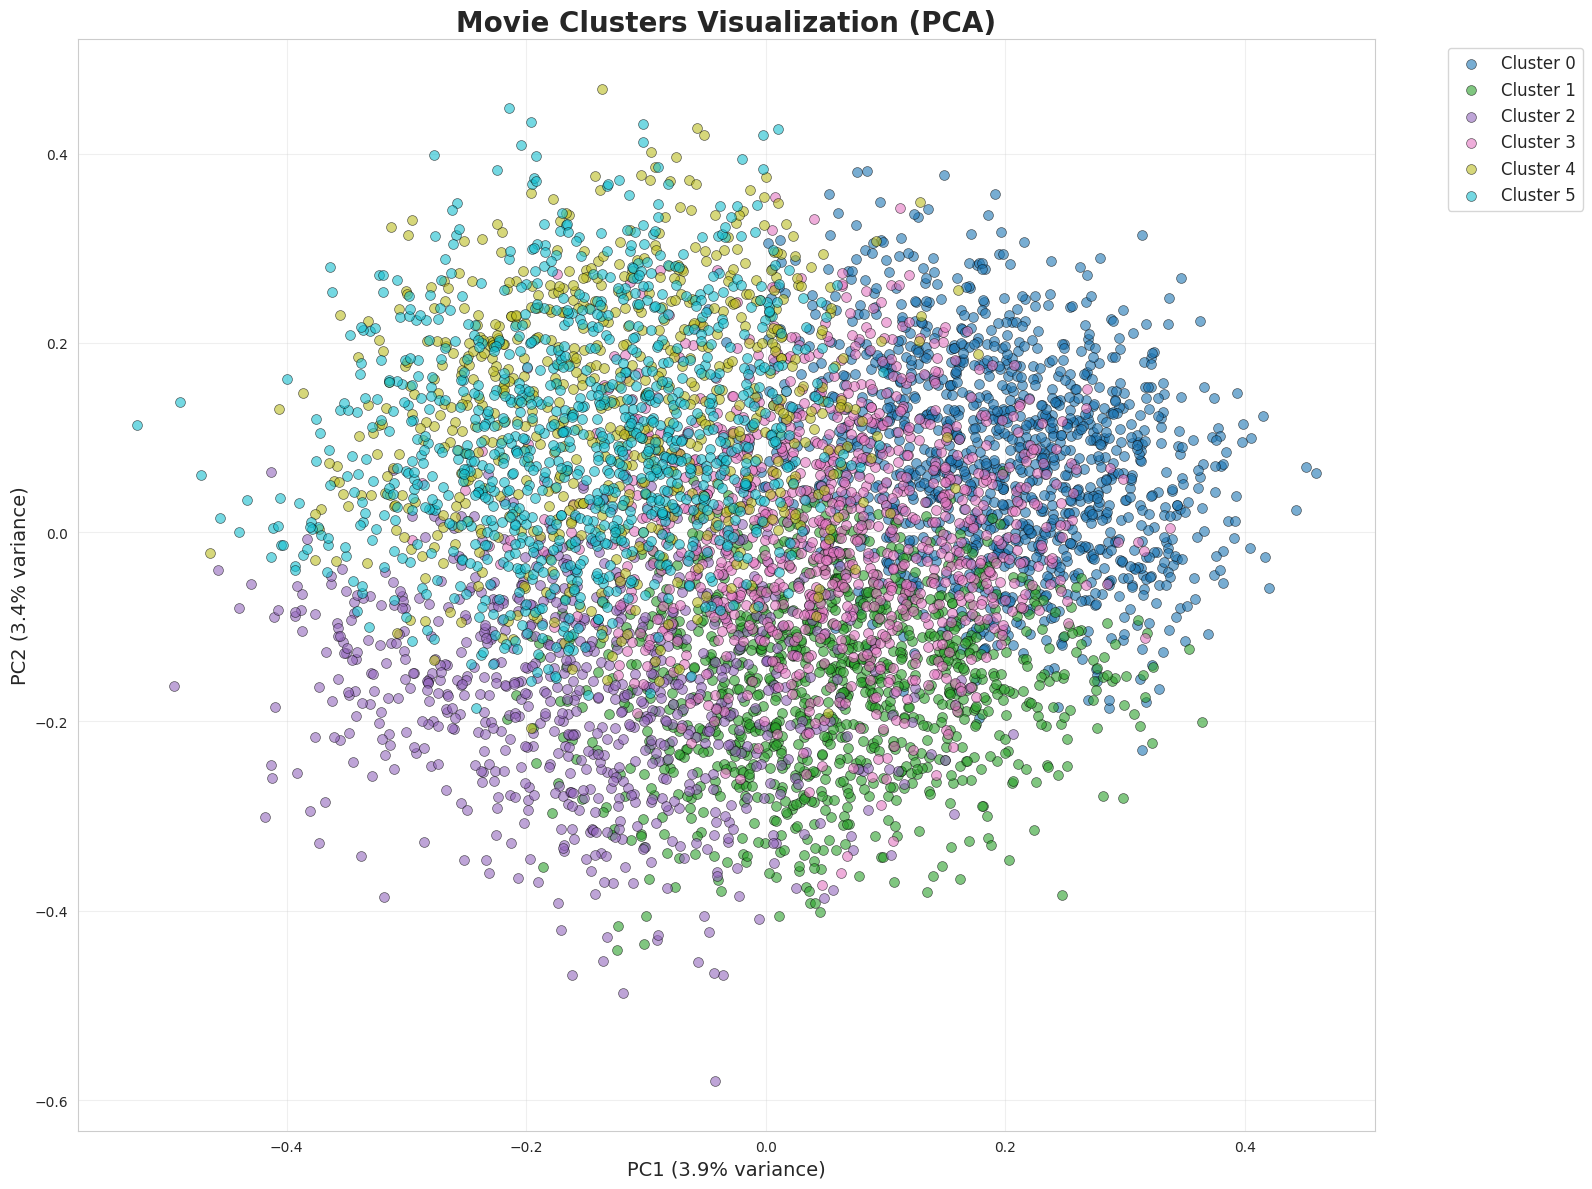

✅ PCA visualization saved!

5. Creating cluster size distribution...


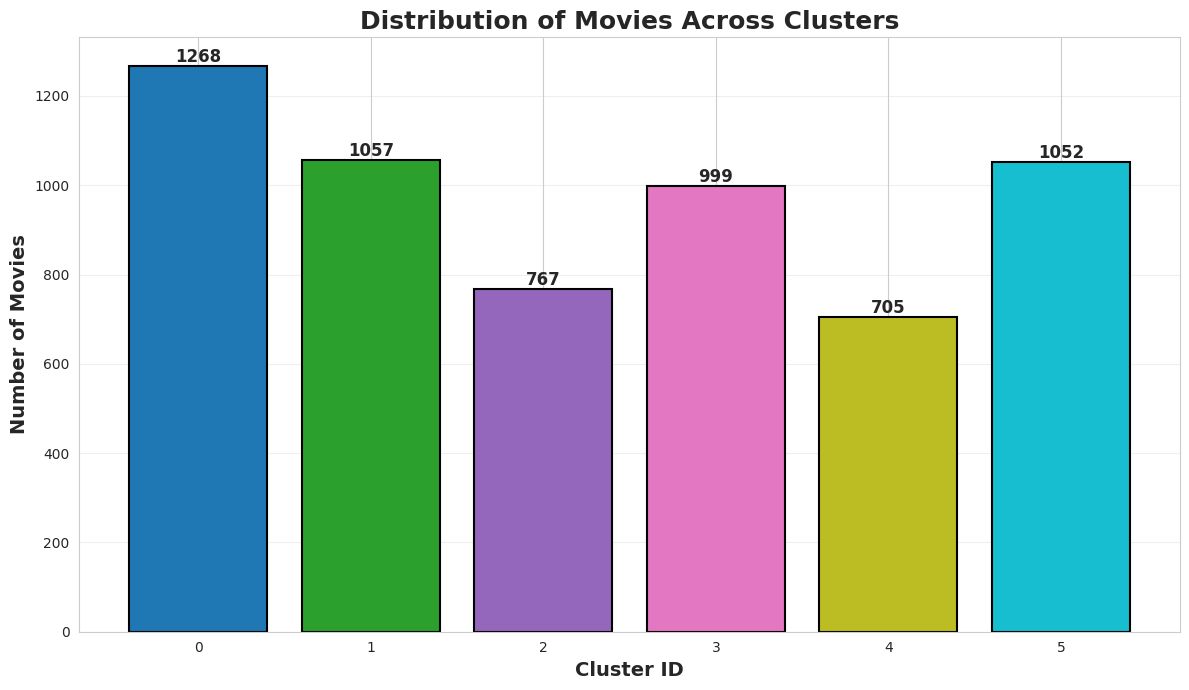

✅ Cluster size distribution saved!

6. Analyzing genre distribution per cluster...


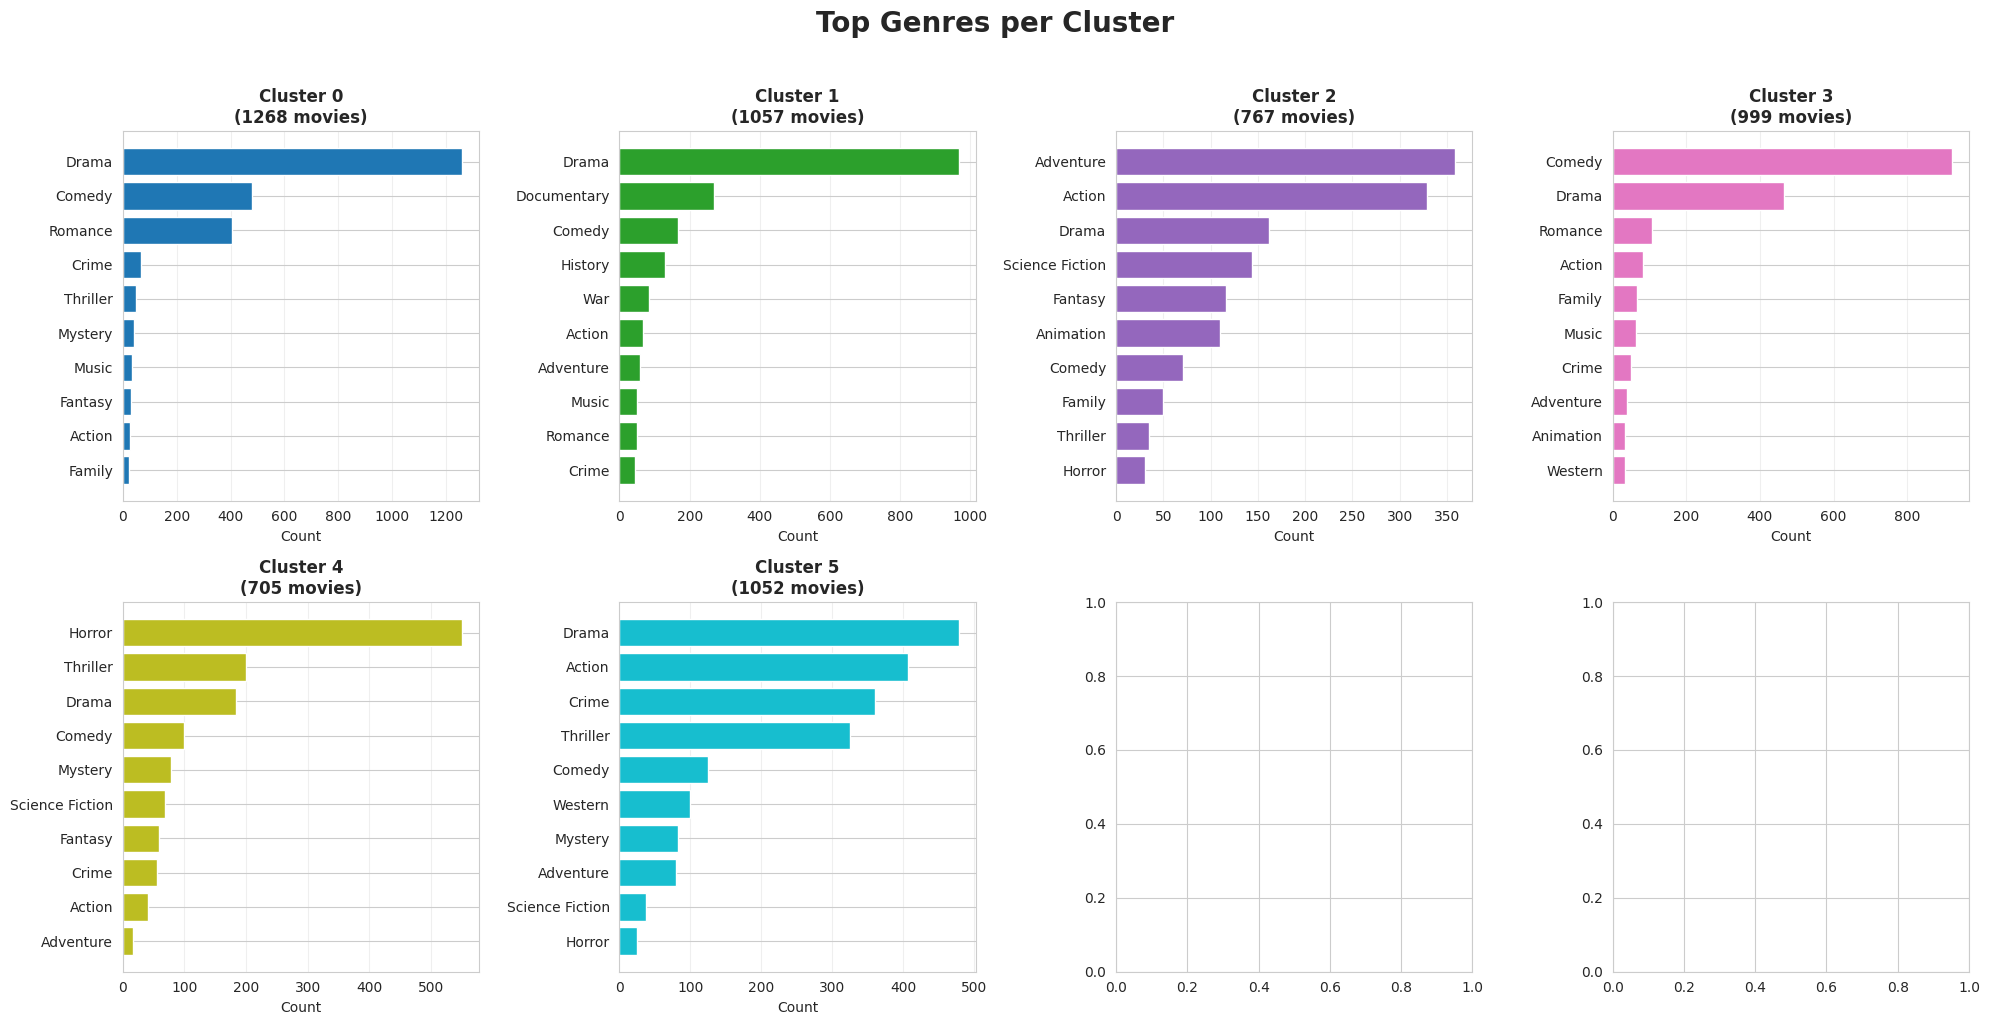

✅ Genre distribution saved!

7. Generating cluster summary...


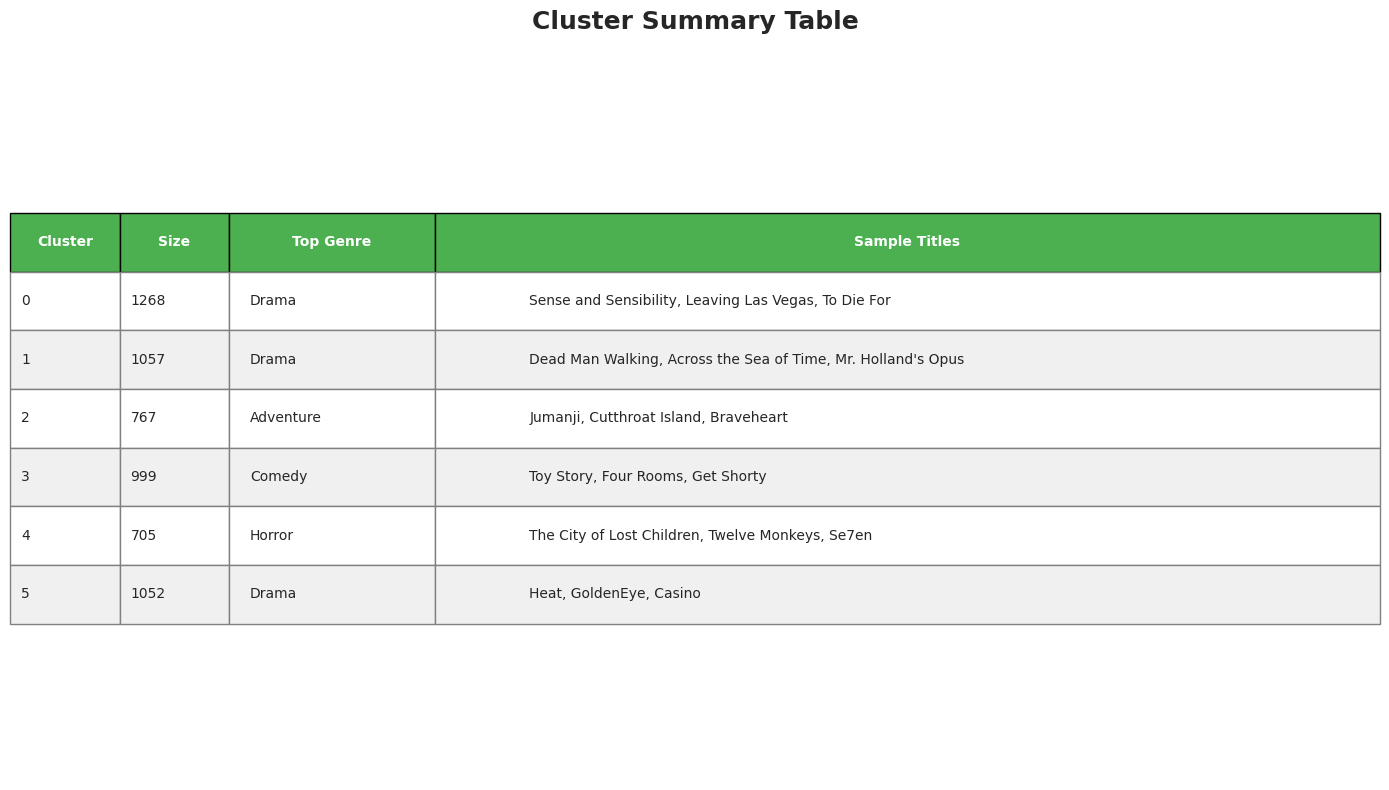

In [38]:
# ============================================================================
# COMPREHENSIVE CLUSTER VISUALIZATION
# ============================================================================
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("="*80)
print("CLUSTER VISUALIZATION SUITE")
print("="*80)

# ============================================================================
# 1. 2D VISUALIZATION USING t-SNE
# ============================================================================

print("\n1. Generating t-SNE 2D projection...")

# Reduce to 2D using t-SNE
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    n_iter=1000,
    verbose=1
)

embeddings_2d = tsne.fit_transform(movie_embeddings)

# Add to dataframe
movies_clean['tsne_x'] = embeddings_2d[:, 0]
movies_clean['tsne_y'] = embeddings_2d[:, 1]

# Plot with matplotlib
fig, ax = plt.subplots(figsize=(16, 12))

colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLUSTERS))

for cluster_id in range(NUM_CLUSTERS):
    cluster_data = movies_clean[movies_clean['cluster'] == cluster_id]
    ax.scatter(
        cluster_data['tsne_x'],
        cluster_data['tsne_y'],
        c=[colors[cluster_id]],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_title('Movie Clusters Visualization (t-SNE)', fontsize=20, fontweight='bold')
ax.set_xlabel('t-SNE Dimension 1', fontsize=14)
ax.set_ylabel('t-SNE Dimension 2', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Movie_Recommendation/cluster_tsne_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ t-SNE visualization saved!")

# ============================================================================
# 2. INTERACTIVE 2D PLOT WITH PLOTLY (with hover info)
# ============================================================================

print("\n2. Creating interactive Plotly visualization...")

fig = px.scatter(
    movies_clean,
    x='tsne_x',
    y='tsne_y',
    color='cluster',
    hover_data=['title', 'genre1', 'genre2'],
    title='Interactive Movie Clusters (t-SNE)',
    labels={'cluster': 'Cluster ID'},
    color_continuous_scale='Viridis',
    width=1200,
    height=800
)

fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    font=dict(size=14),
    title_font_size=20,
    hoverlabel=dict(bgcolor="white", font_size=12)
)

fig.write_html('/content/drive/MyDrive/Movie_Recommendation/cluster_interactive.html')
fig.show()

print("✅ Interactive plot saved as HTML!")

# ============================================================================
# 3. 3D VISUALIZATION USING t-SNE
# ============================================================================

print("\n3. Generating 3D t-SNE projection...")

tsne_3d = TSNE(
    n_components=3,
    random_state=42,
    perplexity=30,
    n_iter=1000
)

embeddings_3d = tsne_3d.fit_transform(movie_embeddings)

movies_clean['tsne_x_3d'] = embeddings_3d[:, 0]
movies_clean['tsne_y_3d'] = embeddings_3d[:, 1]
movies_clean['tsne_z_3d'] = embeddings_3d[:, 2]

# 3D Interactive plot
fig_3d = px.scatter_3d(
    movies_clean,
    x='tsne_x_3d',
    y='tsne_y_3d',
    z='tsne_z_3d',
    color='cluster',
    hover_data=['title', 'genre1', 'genre2'],
    title='3D Movie Clusters (t-SNE)',
    labels={'cluster': 'Cluster ID'},
    color_continuous_scale='Viridis',
    width=1200,
    height=800
)

fig_3d.update_traces(marker=dict(size=5, opacity=0.7))
fig_3d.write_html('/content/drive/MyDrive/Movie_Recommendation/cluster_3d_interactive.html')
fig_3d.show()

print("✅ 3D visualization saved!")

# ============================================================================
# 4. PCA VISUALIZATION (Faster alternative to t-SNE)
# ============================================================================

print("\n4. Generating PCA 2D projection...")

pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(movie_embeddings)

movies_clean['pca_x'] = embeddings_pca[:, 0]
movies_clean['pca_y'] = embeddings_pca[:, 1]

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

fig, ax = plt.subplots(figsize=(16, 12))

for cluster_id in range(NUM_CLUSTERS):
    cluster_data = movies_clean[movies_clean['cluster'] == cluster_id]
    ax.scatter(
        cluster_data['pca_x'],
        cluster_data['pca_y'],
        c=[colors[cluster_id]],
        label=f'Cluster {cluster_id}',
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

ax.set_title('Movie Clusters Visualization (PCA)', fontsize=20, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=14)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Movie_Recommendation/cluster_pca_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ PCA visualization saved!")

# ============================================================================
# 5. CLUSTER SIZE DISTRIBUTION
# ============================================================================

print("\n5. Creating cluster size distribution...")

cluster_sizes = movies_clean['cluster'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(cluster_sizes.index, cluster_sizes.values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Cluster ID', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Movies', fontsize=14, fontweight='bold')
ax.set_title('Distribution of Movies Across Clusters', fontsize=18, fontweight='bold')
ax.set_xticks(range(NUM_CLUSTERS))
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Movie_Recommendation/cluster_sizes.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Cluster size distribution saved!")

# ============================================================================
# 6. GENRE DISTRIBUTION PER CLUSTER
# ============================================================================

print("\n6. Analyzing genre distribution per cluster...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for cluster_id in range(NUM_CLUSTERS):
    cluster_movies = movies_clean[movies_clean['cluster'] == cluster_id]

    # Get top genres
    all_genres = list(cluster_movies['genre1'].dropna()) + list(cluster_movies['genre2'].dropna())
    genre_counts = Counter(all_genres)
    top_genres = dict(genre_counts.most_common(10))

    if top_genres:
        axes[cluster_id].barh(list(top_genres.keys()), list(top_genres.values()), color=colors[cluster_id])
        axes[cluster_id].set_title(f'Cluster {cluster_id}\n({len(cluster_movies)} movies)',
                                    fontsize=12, fontweight='bold')
        axes[cluster_id].set_xlabel('Count', fontsize=10)
        axes[cluster_id].invert_yaxis()
        axes[cluster_id].grid(axis='x', alpha=0.3)

plt.suptitle('Top Genres per Cluster', fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Movie_Recommendation/cluster_genres.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Genre distribution saved!")

# ============================================================================
# 7. CLUSTER SUMMARY STATISTICS
# ============================================================================

print("\n7. Generating cluster summary...")

fig, ax = plt.subplots(figsize=(14, 8))

summary_data = []
for cluster_id in range(NUM_CLUSTERS):
    cluster_movies = movies_clean[movies_clean['cluster'] == cluster_id]
    all_genres = list(cluster_movies['genre1'].dropna()) + list(cluster_movies['genre2'].dropna())
    top_genre = Counter(all_genres).most_common(1)[0][0] if all_genres else 'Unknown'

    summary_data.append({
        'Cluster': cluster_id,
        'Size': len(cluster_movies),
        'Top Genre': top_genre,
        'Sample Titles': ', '.join(cluster_movies['title'].head(3).tolist())
    })

summary_df = pd.DataFrame(summary_data)

# Create table
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='left',
    loc='center',
    colWidths=[0.08, 0.08, 0.15, 0.69]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 3)

# Style header
for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style rows with alternating colors
for i in range(1, len(summary_df) + 1):
    for j in range(len(summary_df.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        table[(i, j)].set_edgecolor('gray')

ax.axis('off')
ax.set_title('Cluster Summary Table', fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Movie_Recommendation/cluster_summary.png', dpi=300, bbox_inches='tight')
plt.show()


### **B. MiniLM + Cosine Similarity**

In [39]:
file_path = "/content/drive/MyDrive/Movie_Recommendation/movies.csv"

movies_nlp = pd.read_csv(file_path)

#cleans up the data and convert it to integer
movies_nlp['id'] = pd.to_numeric(movies_nlp['id'], errors='coerce')


In [43]:

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer


model = SentenceTransformer("all-MiniLM-L6-v2")
print("Generating overview embeddings...")
full_embeddings= model.encode(movies_nlp['overview'].tolist(), show_progress_bar=True)

# Save to disk if needed
np.save('full_embeddings.npy', full_embeddings)

Generating overview embeddings...


Batches:   0%|          | 0/1022 [00:00<?, ?it/s]

In [44]:
#Finding Similar Movies Using Combined Overview and Keywords Embeddings
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_movies(movie_id, embeddings, df, top_n=10):
    if movie_id not in df.index.values:
        print(f"Movie ID {movie_id} not found.")
        return None
    print(f"Finding similar movies for '{df[df.index == movie_id]['title'].values[0]}'")
    embedded_overview = model.encode(df[df.index == movie_id]['overview'].tolist())[0].reshape(1, -1)

    similarity_scores = cosine_similarity(
        embedded_overview
        , embeddings
    )[0]
    similar_indices = similarity_scores.argsort()[-top_n-1:-1][::-1]  # exclude itself
    return df.iloc[similar_indices][['title']]

similar_movies = get_similar_movies(1930, full_embeddings, movies_nlp)
similar_movies

Finding similar movies for 'Pleasantville'


,title
4050,Wish Upon a Star
3004,What Ever Happened to Baby Jane?
11990,I Can Do Bad All By Myself
12804,Little Fugitive
31731,The Black Room
4578,Calamity Jane
22560,Forgotten
32151,Center of My World
941,Rebel Without a Cause
1558,Henry Fool


CONTENT-BASED RECOMMENDATION EVALUATION

1. GENRE CONSISTENCY EVALUATION
--------------------------------------------------------------------------------
Finding similar movies for 'Toy Story'
Finding similar movies for 'Jumanji'
Finding similar movies for 'Grumpier Old Men'
Finding similar movies for 'Waiting to Exhale'
Finding similar movies for 'Father of the Bride Part II'
Finding similar movies for 'Heat'
Finding similar movies for 'Sabrina'
Finding similar movies for 'Tom and Huck'
Finding similar movies for 'Sudden Death'
Finding similar movies for 'GoldenEye'
Finding similar movies for 'The American President'
Finding similar movies for 'Dracula: Dead and Loving It'
Finding similar movies for 'Balto'
Finding similar movies for 'Nixon'
Finding similar movies for 'Cutthroat Island'
Finding similar movies for 'Casino'
Finding similar movies for 'Sense and Sensibility'
Finding similar movies for 'Four Rooms'
Finding similar movies for 'Ace Ventura: When Nature Calls'
Finding simila

/tmp/ipython-input-1519937986.py:355: UserWarning:

Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.

/tmp/ipython-input-1519937986.py:356: UserWarning:

Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.



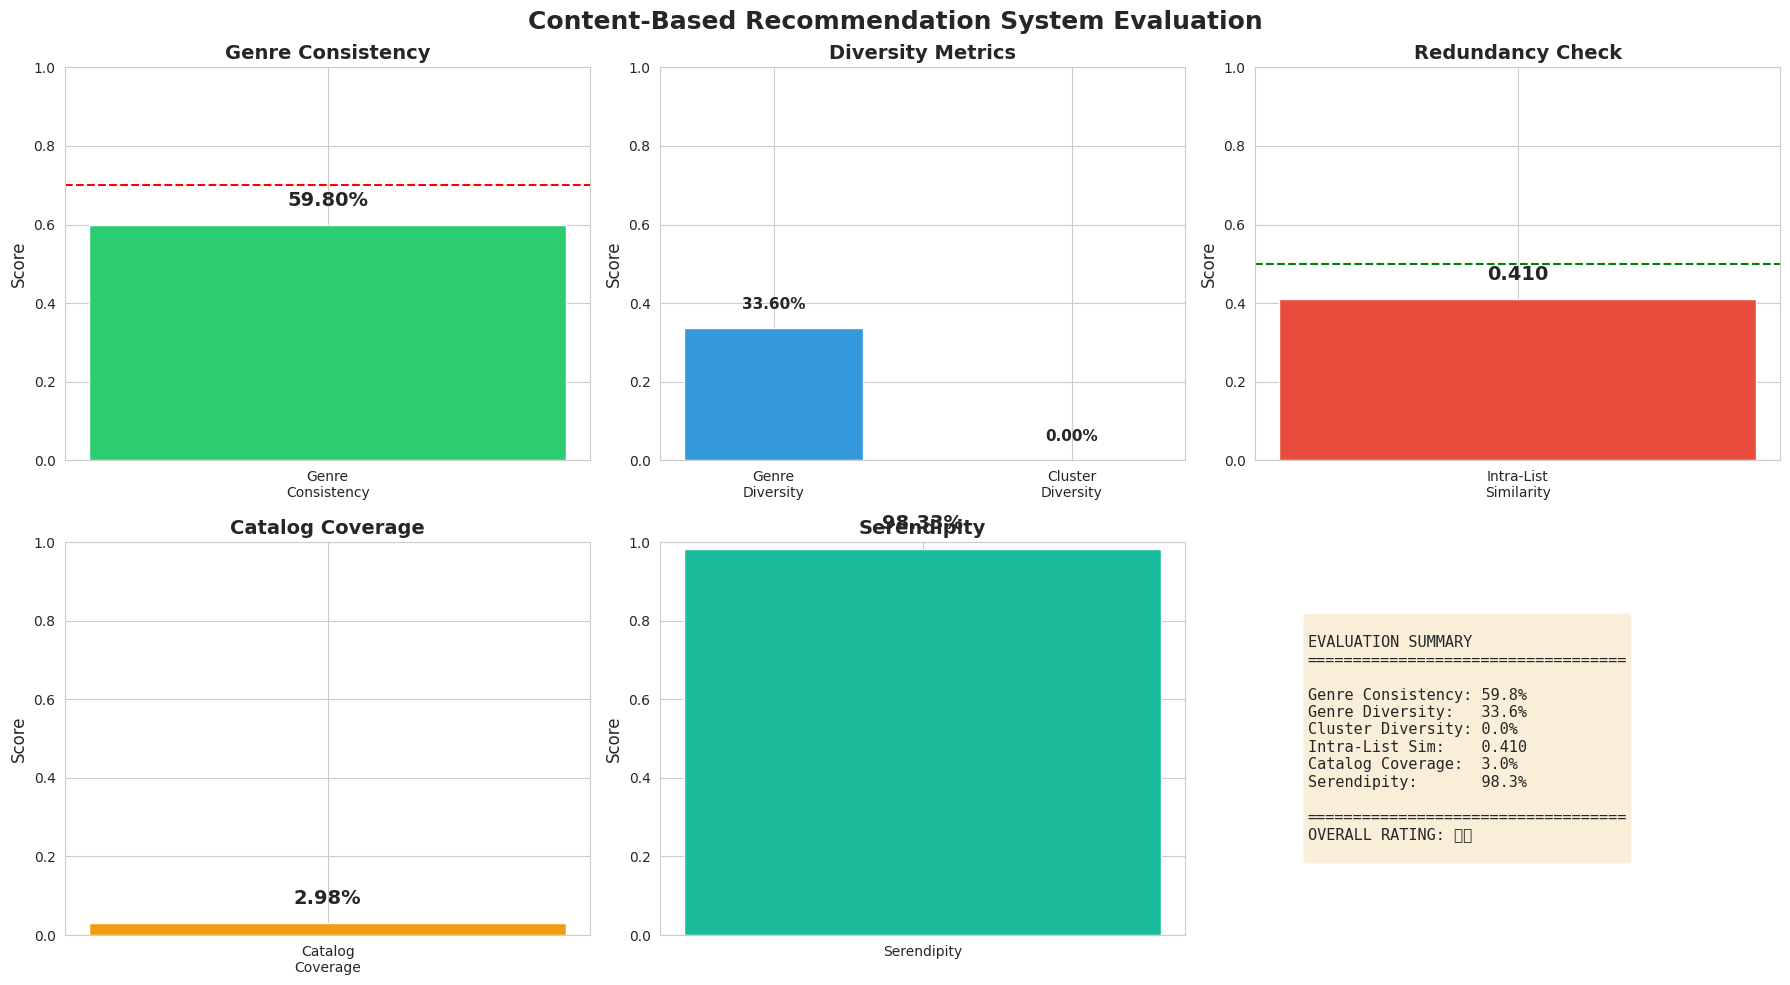


✅ Evaluation summary saved!

EVALUATION COMPLETE - FINAL REPORT

📊 CONTENT-BASED RECOMMENDATION SYSTEM EVALUATION

1. Genre Consistency:      59.8%  ⚠️
   → Recommended movies share genres with query movie

2. Genre Diversity:        33.6%  ⚠️
   → Recommendations span multiple genres

3. Cluster Diversity:      0.0%  ⚠️
   → Recommendations from different content clusters

4. Intra-List Similarity:  0.410  ✅
   → Low redundancy in recommendations

5. Catalog Coverage:       3.0%  ⚠️
   → Diverse movies get recommended

6. Serendipity:           98.3%  ✅
   → Non-obvious but relevant recommendations

RECOMMENDATIONS FOR IMPROVEMENT:

  • Increase weight on genre/keyword embeddings
  • Consider boosting less popular movies

✅ All evaluation results saved to Drive!


In [45]:
# ============================================================================
# COMPREHENSIVE EVALUATION FOR CONTENT-BASED RECOMMENDATIONS
# ============================================================================

from collections import Counter

print("="*80)
print("CONTENT-BASED RECOMMENDATION EVALUATION")
print("="*80)

# ============================================================================
# 1. GENRE CONSISTENCY EVALUATION
# ============================================================================

def evaluate_genre_consistency(movie_id, recommended_ids, df):
    """
    Measure if recommended movies share genres with the query movie
    """
    if movie_id not in df.index:
        return None

    # Get genres of query movie
    query_genres = set()
    if 'genre1' in df.columns:
        query_genres.add(df.loc[movie_id, 'genre1'])
    if 'genre2' in df.columns:
        query_genres.add(df.loc[movie_id, 'genre2'])
    query_genres.discard(None)

    # Check recommended movies
    genre_matches = []
    for rec_id in recommended_ids:
        rec_genres = set()
        if 'genre1' in df.columns:
            rec_genres.add(df.loc[rec_id, 'genre1'])
        if 'genre2' in df.columns:
            rec_genres.add(df.loc[rec_id, 'genre2'])
        rec_genres.discard(None)

        # Calculate overlap
        overlap = len(query_genres.intersection(rec_genres))
        genre_matches.append(overlap > 0)

    consistency = np.mean(genre_matches) if genre_matches else 0
    return {
        'query_genres': query_genres,
        'consistency_score': consistency,
        'matching_movies': sum(genre_matches)
    }

print("\n1. GENRE CONSISTENCY EVALUATION")
print("-" * 80)

# Test on sample movies
test_movie_ids = movies_nlp.index[:50]  # Test first 50 movies
genre_scores = []

for movie_id in test_movie_ids:
    # Get recommendations
    similar = get_similar_movies(movie_id, full_embeddings, movies_nlp, top_n=10)
    if similar is not None:
        rec_ids = similar.index.tolist()
        result = evaluate_genre_consistency(movie_id, rec_ids, movies_nlp)
        if result:
            genre_scores.append(result['consistency_score'])

avg_genre_consistency = np.mean(genre_scores) if genre_scores else 0
print(f"\n✅ Average Genre Consistency: {avg_genre_consistency:.2%}")
print(f"   (% of recommended movies sharing at least 1 genre with query movie)")

# ============================================================================
# 2. DIVERSITY EVALUATION
# ============================================================================

def evaluate_diversity(recommended_ids, df):
    """
    Measure diversity in recommendations (not all from same genre/cluster)
    """
    # Genre diversity
    all_genres = []
    for rec_id in recommended_ids:
        if 'genre1' in df.columns and df.loc[rec_id, 'genre1']:
            all_genres.append(df.loc[rec_id, 'genre1'])
        if 'genre2' in df.columns and df.loc[rec_id, 'genre2']:
            all_genres.append(df.loc[rec_id, 'genre2'])

    unique_genres = len(set(all_genres))
    total_genres = len(all_genres)
    genre_diversity = unique_genres / total_genres if total_genres > 0 else 0

    # Cluster diversity (if available)
    cluster_diversity = 0
    if 'cluster' in df.columns:
        clusters = [df.loc[rec_id, 'cluster'] for rec_id in recommended_ids if rec_id in df.index]
        unique_clusters = len(set(clusters))
        cluster_diversity = unique_clusters / len(clusters) if clusters else 0

    return {
        'genre_diversity': genre_diversity,
        'cluster_diversity': cluster_diversity,
        'unique_genres': unique_genres
    }

print("\n2. DIVERSITY EVALUATION")
print("-" * 80)

diversity_scores = []
for movie_id in test_movie_ids:
    similar = get_similar_movies(movie_id, full_embeddings, movies_nlp, top_n=10)
    if similar is not None:
        diversity = evaluate_diversity(similar.index.tolist(), movies_nlp)
        diversity_scores.append(diversity)

avg_genre_diversity = np.mean([d['genre_diversity'] for d in diversity_scores])
avg_cluster_diversity = np.mean([d['cluster_diversity'] for d in diversity_scores])

print(f"\n✅ Average Genre Diversity: {avg_genre_diversity:.2%}")
print(f"✅ Average Cluster Diversity: {avg_cluster_diversity:.2%}")
print(f"   (Higher = more diverse recommendations)")

# ============================================================================
# 3. INTRA-LIST SIMILARITY (Redundancy Check)
# ============================================================================

def calculate_intra_list_similarity(recommended_ids, embeddings, df):
    """
    Measure how similar recommended movies are to each other
    Lower = more diverse recommendations
    """
    # Get embeddings for recommended movies
    indices = [df.index.get_loc(rec_id) for rec_id in recommended_ids if rec_id in df.index]
    rec_embeddings = embeddings[indices]

    # Calculate pairwise similarities
    similarities = cosine_similarity(rec_embeddings)

    # Get upper triangle (exclude diagonal)
    upper_triangle = similarities[np.triu_indices_from(similarities, k=1)]

    return {
        'mean_similarity': np.mean(upper_triangle),
        'max_similarity': np.max(upper_triangle),
        'min_similarity': np.min(upper_triangle)
    }

print("\n3. INTRA-LIST SIMILARITY (Redundancy Check)")
print("-" * 80)

intra_similarities = []
for movie_id in test_movie_ids[:20]:  # Test fewer due to computational cost
    similar = get_similar_movies(movie_id, full_embeddings, movies_nlp, top_n=10)
    if similar is not None:
        intra_sim = calculate_intra_list_similarity(
            similar.index.tolist(),
            full_embeddings,
            movies_nlp
        )
        intra_similarities.append(intra_sim['mean_similarity'])

avg_intra_similarity = np.mean(intra_similarities)
print(f"\n✅ Average Intra-List Similarity: {avg_intra_similarity:.3f}")
print(f"   (0.0 = very diverse, 1.0 = redundant recommendations)")
if avg_intra_similarity > 0.8:
    print("   ⚠️  High redundancy detected - recommendations may be too similar")
elif avg_intra_similarity < 0.5:
    print("   ✅ Good diversity - recommendations are varied")

# ============================================================================
# 4. COVERAGE EVALUATION
# ============================================================================

def evaluate_coverage(df, embeddings, top_n=10, sample_size=100):
    """
    Measure what % of movies get recommended (avoid popularity bias)
    """
    recommended_movies = set()

    # Sample random movies as queries
    sample_ids = np.random.choice(df.index, min(sample_size, len(df)), replace=False)

    for movie_id in sample_ids:
        similar = get_similar_movies(movie_id, embeddings, df, top_n=top_n)
        if similar is not None:
            recommended_movies.update(similar.index.tolist())

    coverage = len(recommended_movies) / len(df)
    return coverage, len(recommended_movies)

print("\n4. CATALOG COVERAGE")
print("-" * 80)

coverage, num_recommended = evaluate_coverage(movies_nlp, full_embeddings, top_n=10, sample_size=100)
print(f"\n✅ Catalog Coverage: {coverage:.2%}")
print(f"   ({num_recommended} out of {len(movies_nlp)} movies recommended)")
if coverage < 0.3:
    print("   ⚠️  Low coverage - many movies never get recommended")
else:
    print("   ✅ Good coverage - recommendations span diverse content")

# ============================================================================
# 5. SERENDIPITY (Unexpected but Relevant)
# ============================================================================

def evaluate_serendipity(movie_id, recommended_ids, df):
    """
    Measure if recommendations are similar BUT not TOO obvious
    Good recommendations: related but not from exact same genre/franchise
    """
    query_title = df.loc[movie_id, 'title']

    # Check for franchise/sequel patterns
    obvious_count = 0
    for rec_id in recommended_ids:
        rec_title = df.loc[rec_id, 'title']

        # Very simple check: shared words in title (excluding common words)
        query_words = set(query_title.lower().split()) - {'the', 'a', 'an', 'of', 'in', 'and'}
        rec_words = set(rec_title.lower().split()) - {'the', 'a', 'an', 'of', 'in', 'and'}

        if len(query_words.intersection(rec_words)) >= 2:
            obvious_count += 1

    serendipity = 1 - (obvious_count / len(recommended_ids))
    return serendipity

print("\n5. SERENDIPITY (Non-Obvious Recommendations)")
print("-" * 80)

serendipity_scores = []
for movie_id in test_movie_ids[:30]:
    similar = get_similar_movies(movie_id, full_embeddings, movies_nlp, top_n=10)
    if similar is not None:
        serendipity = evaluate_serendipity(movie_id, similar.index.tolist(), movies_nlp)
        serendipity_scores.append(serendipity)

avg_serendipity = np.mean(serendipity_scores)
print(f"\n✅ Average Serendipity: {avg_serendipity:.2%}")
print(f"   (Higher = less obvious, more surprising recommendations)")

# ============================================================================
# 6. QUALITATIVE EVALUATION - SAMPLE ANALYSIS
# ============================================================================

print("\n6. QUALITATIVE ANALYSIS - SAMPLE RECOMMENDATIONS")
print("-" * 80)

# Analyze a few examples
sample_movies = [1930, 862, 680]  # Test specific movies

for movie_id in sample_movies:
    if movie_id not in movies_nlp.index:
        continue

    print(f"\n{'='*70}")
    print(f"Query Movie: {movies_nlp.loc[movie_id, 'title']}")
    if 'genre1' in movies_nlp.columns:
        print(f"Genre: {movies_nlp.loc[movie_id, 'genre1']}")
    print(f"{'='*70}")

    # Get recommendations
    similar = get_similar_movies(movie_id, full_embeddings, movies_nlp, top_n=10)

    if similar is not None:
        # Evaluate this recommendation list
        genre_eval = evaluate_genre_consistency(movie_id, similar.index.tolist(), movies_nlp)
        diversity_eval = evaluate_diversity(similar.index.tolist(), movies_nlp)

        print(f"\nGenre Consistency: {genre_eval['consistency_score']:.0%}")
        print(f"Genre Diversity: {diversity_eval['genre_diversity']:.2f}")

        print("\nTop 5 Recommendations:")
        for i, (idx, row) in enumerate(similar.head(5).iterrows(), 1):
            genre = movies_nlp.loc[idx, 'genre1'] if 'genre1' in movies_nlp.columns else 'N/A'
            print(f"  {i}. {row['title']} ({genre})")

# ============================================================================
# 7. SUMMARY VISUALIZATION
# ============================================================================

print("\n7. GENERATING EVALUATION SUMMARY")
print("-" * 80)

# Create summary plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Content-Based Recommendation System Evaluation', fontsize=18, fontweight='bold')

# 1. Genre Consistency
axes[0, 0].bar(['Genre\nConsistency'], [avg_genre_consistency], color='#2ecc71', width=0.5)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].set_title('Genre Consistency', fontsize=14, fontweight='bold')
axes[0, 0].axhline(y=0.7, color='r', linestyle='--', label='Target: 0.7')
axes[0, 0].text(0, avg_genre_consistency + 0.05, f'{avg_genre_consistency:.2%}',
                ha='center', fontsize=14, fontweight='bold')

# 2. Diversity
diversity_data = [avg_genre_diversity, avg_cluster_diversity]
axes[0, 1].bar(['Genre\nDiversity', 'Cluster\nDiversity'], diversity_data,
               color=['#3498db', '#9b59b6'], width=0.6)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].set_title('Diversity Metrics', fontsize=14, fontweight='bold')
for i, v in enumerate(diversity_data):
    axes[0, 1].text(i, v + 0.05, f'{v:.2%}', ha='center', fontsize=11, fontweight='bold')

# 3. Intra-List Similarity
axes[0, 2].bar(['Intra-List\nSimilarity'], [avg_intra_similarity], color='#e74c3c', width=0.5)
axes[0, 2].set_ylim(0, 1)
axes[0, 2].set_ylabel('Score', fontsize=12)
axes[0, 2].set_title('Redundancy Check', fontsize=14, fontweight='bold')
axes[0, 2].axhline(y=0.5, color='g', linestyle='--', label='Target: <0.5')
axes[0, 2].text(0, avg_intra_similarity + 0.05, f'{avg_intra_similarity:.3f}',
                ha='center', fontsize=14, fontweight='bold')

# 4. Coverage
axes[1, 0].bar(['Catalog\nCoverage'], [coverage], color='#f39c12', width=0.5)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Catalog Coverage', fontsize=14, fontweight='bold')
axes[1, 0].text(0, coverage + 0.05, f'{coverage:.2%}', ha='center', fontsize=14, fontweight='bold')

# 5. Serendipity
axes[1, 1].bar(['Serendipity'], [avg_serendipity], color='#1abc9c', width=0.5)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('Serendipity', fontsize=14, fontweight='bold')
axes[1, 1].text(0, avg_serendipity + 0.05, f'{avg_serendipity:.2%}',
                ha='center', fontsize=14, fontweight='bold')

# 6. Overall Summary Table
summary_text = f"""
EVALUATION SUMMARY
{'='*35}

Genre Consistency: {avg_genre_consistency:.1%}
Genre Diversity:   {avg_genre_diversity:.1%}
Cluster Diversity: {avg_cluster_diversity:.1%}
Intra-List Sim:    {avg_intra_similarity:.3f}
Catalog Coverage:  {coverage:.1%}
Serendipity:       {avg_serendipity:.1%}

{'='*35}
OVERALL RATING: {'⭐' * int(avg_genre_consistency * 5)}
"""

axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Movie_Recommendation/recommendation_evaluation.png',
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Evaluation summary saved!")

# ============================================================================
# 8. FINAL REPORT
# ============================================================================

print("\n" + "="*80)
print("EVALUATION COMPLETE - FINAL REPORT")
print("="*80)

print(f"""
📊 CONTENT-BASED RECOMMENDATION SYSTEM EVALUATION

1. Genre Consistency:      {avg_genre_consistency:.1%}  {'✅' if avg_genre_consistency > 0.7 else '⚠️'}
   → Recommended movies share genres with query movie

2. Genre Diversity:        {avg_genre_diversity:.1%}  {'✅' if avg_genre_diversity > 0.5 else '⚠️'}
   → Recommendations span multiple genres

3. Cluster Diversity:      {avg_cluster_diversity:.1%}  {'✅' if avg_cluster_diversity > 0.4 else '⚠️'}
   → Recommendations from different content clusters

4. Intra-List Similarity:  {avg_intra_similarity:.3f}  {'✅' if avg_intra_similarity < 0.6 else '⚠️'}
   → Low redundancy in recommendations

5. Catalog Coverage:       {coverage:.1%}  {'✅' if coverage > 0.3 else '⚠️'}
   → Diverse movies get recommended

6. Serendipity:           {avg_serendipity:.1%}  {'✅' if avg_serendipity > 0.7 else '⚠️'}
   → Non-obvious but relevant recommendations

{'='*80}
RECOMMENDATIONS FOR IMPROVEMENT:
""")

## **3. Integration and Insight**


We integrated the clusters obtained from K-Means clustering (using MPNet embeddings) into our supervised models — XGBoost and Random Forest — by merging cluster labels as categorical features and adding distances to cluster centroids as continuous features.

**Integration Steps:**

- Cluster labels were merged into the main dataset based on movie IDs.
- One-hot encoding was applied to cluster labels to create categorical features.
- Euclidean distances to cluster centroids were added as additional features.
- Different feature combinations were tested: base features, base + cluster, base + distances, and base + both.

**Results:**

The addition of clustering features resulted in negligible improvements or slight performance drops in RMSE and MAE compared to baseline models without clustering.


**Reasons for Limited Improvement:**

- The filtered dataset for clustering was smaller, possibly limiting cluster quality.
- Feature importance analysis showed numeric features (runtime, average rating) dominated predictions over content-based features.
- Moderate cluster quality (silhouette scores) suggests clusters were not strongly distinct.
- User ratings may be influenced by external factors not captured by semantic embeddings.


In [46]:
# ============================================
# CORRECTED PIPELINE - BUILD FEATURES AFTER MERGE
# ============================================

from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

warnings.filterwarnings("ignore")


# ===============================================================
# 1) MERGE CLUSTERS FIRST
# ===============================================================
reduced_sampled['movieId'] = reduced_sampled['movieId'].astype(str)
movies_clean['id'] = movies_clean['id'].astype(str)

reduced_sampled = reduced_sampled.merge(
    movies_clean[['id', 'cluster']],
    left_on='movieId',
    right_on='id',
    how='left'
)

reduced_sampled.drop(columns=['id'], inplace=True)

print("Cluster labels merged. Sample:")
print(reduced_sampled[['movieId', 'cluster']].head())
print("Rows in reduced_sampled:", len(reduced_sampled))


# ===============================================================
# 2) NOW BUILD ALL FEATURES FROM THE MERGED DATA
# ===============================================================

# Text features
reduced_sampled['title'] = reduced_sampled['title'].fillna('').astype(str)
reduced_sampled['overview'] = reduced_sampled['overview'].fillna('').astype(str)

tfidf_overview = TfidfVectorizer(max_features=5000, stop_words='english')
overview_features = tfidf_overview.fit_transform(reduced_sampled['overview'])

tfidf_title = TfidfVectorizer(max_features=200, stop_words='english')
title_features = tfidf_title.fit_transform(reduced_sampled['title'])

# Numeric features
numeric_cols = [col for col in reduced_sampled.columns
                if col not in ['userId','movieId','overview','title','rating','cluster']]

X_numeric = csr_matrix(reduced_sampled[numeric_cols].values)

# Target
y = reduced_sampled['rating'].values

print(f"X_numeric: {X_numeric.shape}")
print(f"overview_features: {overview_features.shape}")
print(f"title_features: {title_features.shape}")
print(f"y: {y.shape}")


# ===============================================================
# 3) CLUSTER ONE-HOT
# ===============================================================

cluster_arr = reduced_sampled['cluster'].fillna(-1).astype(int).values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
cluster_ohe = ohe.fit_transform(cluster_arr)
print(f"cluster_ohe: {cluster_ohe.shape}")


# ===============================================================
# 4) EXPAND EMBEDDINGS TO MATCH EACH RATING ROW
# ===============================================================

# Build mapping: movieId → embedding row index
movies_clean["id"] = movies_clean["id"].astype(int)
movieId_to_index = {mid: i for i, mid in enumerate(movies_clean["id"].tolist())}

# Expand embedding matrix to match reduced_sampled row-by-row
movie_ids = reduced_sampled["movieId"].astype(int).tolist()

emb_matrix = np.vstack([
    movie_embeddings[movieId_to_index[mid]]
    for mid in movie_ids
])

print(f"aligned embedding matrix: {emb_matrix.shape}")

# Compute distances
centroids = kmeans.cluster_centers_
distances = pairwise_distances(emb_matrix, centroids, metric="euclidean")
distances_sparse = csr_matrix(distances)
print(f"distances_sparse: {distances_sparse.shape}")


# ===============================================================
# 5) BUILD FEATURE MATRICES (NOW ALL DIMENSIONS MATCH!)
# ===============================================================

X_base = hstack([X_numeric, overview_features, title_features])
print(f"X_base: {X_base.shape}")

X_with_cluster = hstack([X_base, cluster_ohe])
print(f"X_with_cluster: {X_with_cluster.shape}")

X_with_distances = hstack([X_base, distances_sparse])
print(f"X_with_distances: {X_with_distances.shape}")

X_with_both = hstack([X_base, cluster_ohe, distances_sparse])
print(f"X_with_both: {X_with_both.shape}")


# ===============================================================
# 6) TRAIN/TEST SPLIT
# ===============================================================

RANDOM_STATE = 42
indices = np.arange(X_base.shape[0])
idx_train, idx_test = train_test_split(indices, test_size=0.2, random_state=RANDOM_STATE)

def slice_sparse(X, idx):
    return X[idx]

Xb_train = slice_sparse(X_base, idx_train)
Xb_test  = slice_sparse(X_base, idx_test)

Xc_train = slice_sparse(X_with_cluster, idx_train)
Xc_test  = slice_sparse(X_with_cluster, idx_test)

Xd_train = slice_sparse(X_with_distances, idx_train)
Xd_test  = slice_sparse(X_with_distances, idx_test)

Xbd_train = slice_sparse(X_with_both, idx_train)
Xbd_test  = slice_sparse(X_with_both, idx_test)

y_train = y[idx_train]
y_test  = y[idx_test]

print(f"\nTrain/test split complete:")
print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")


# ===============================================================
# 7) TRAINING FUNCTION
# ===============================================================

def train_and_evaluate(model, X_train, X_test, y_train, y_test, name="model"):
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_train = mean_absolute_error(y_train, y_pred_train)

    return {
        'name': name,
        'rmse_test': rmse_test,
        'mae_test': mae_test,
        'rmse_train': rmse_train,
        'mae_train': mae_train
    }


# ===============================================================
# 8) MODELS & EXPERIMENTS
# ===============================================================

xgb_params = dict(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.5,
    random_state=RANDOM_STATE,
    tree_method='hist',
    n_jobs=-1
)

rf_params = dict(
    n_estimators=200,
    max_depth=15,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

results = []

# XGB baseline
results.append(train_and_evaluate(
    XGBRegressor(**xgb_params),
    Xb_train, Xb_test, y_train, y_test,
    "XGB_baseline"
))

# XGB + cluster
results.append(train_and_evaluate(
    XGBRegressor(**xgb_params),
    Xc_train, Xc_test, y_train, y_test,
    "XGB_with_cluster"
))

# XGB + distances
results.append(train_and_evaluate(
    XGBRegressor(**xgb_params),
    Xd_train, Xd_test, y_train, y_test,
    "XGB_with_distances"
))

# XGB + both
results.append(train_and_evaluate(
    XGBRegressor(**xgb_params),
    Xbd_train, Xbd_test, y_train, y_test,
    "XGB_with_both"
))

# RF baseline
results.append(train_and_evaluate(
    RandomForestRegressor(**rf_params),
    Xb_train, Xb_test, y_train, y_test,
    "RF_baseline"
))

# RF + cluster
results.append(train_and_evaluate(
    RandomForestRegressor(**rf_params),
    Xc_train, Xc_test, y_train, y_test,
    "RF_with_cluster"
))


# ===============================================================
# 9) SUMMARY
# ===============================================================

results_df = pd.DataFrame(results).set_index('name')
print("\n" + "="*60)
print("SUMMARY OF EXPERIMENTS")
print("="*60)
print(results_df.to_string())

base_rmse = results_df.loc['XGB_baseline', 'rmse_test']

print("\n" + "="*60)
print("IMPROVEMENTS VS BASELINE")
print("="*60)
for idx, row in results_df.iterrows():
    improvement = (base_rmse - row['rmse_test']) / base_rmse * 100
    print(f"{idx:20s}: RMSE={row['rmse_test']:.4f}  ({improvement:+.2f}%)")

Cluster labels merged. Sample:
  movieId  cluster
0       2        2
1       2        2
2       2        2
3       2        2
4       2        2
Rows in reduced_sampled: 587241
X_numeric: (587241, 13)
overview_features: (587241, 5000)
title_features: (587241, 200)
y: (587241,)
cluster_ohe: (587241, 6)
aligned embedding matrix: (587241, 768)
distances_sparse: (587241, 6)
X_base: (587241, 5213)
X_with_cluster: (587241, 5219)
X_with_distances: (587241, 5219)
X_with_both: (587241, 5225)

Train/test split complete:
Train size: 469792, Test size: 117449

Training XGB_baseline...

Training XGB_with_cluster...

Training XGB_with_distances...

Training XGB_with_both...

Training RF_baseline...

Training RF_with_cluster...

SUMMARY OF EXPERIMENTS
                    rmse_test  mae_test  rmse_train  mae_train
name                                                          
XGB_baseline         0.988554  0.789013    0.991397   0.792048
XGB_with_cluster     0.987917  0.788338    0.990765   0.791334
X

## **References**
[1] [Elbow Method](https://www.geeksforgeeks.org/machine-learning/elbow-method-for-optimal-value-of-k-in-kmeans/)

[2] [Cosine Similarity](https://www.geeksforgeeks.org/dbms/cosine-similarity/)